In [1]:
import asyncio
import websockets
import json
import pandas as pd
import nest_asyncio
import matplotlib.pyplot as plt
nest_asyncio.apply()
import warnings
import numpy as np
import datetime
from utils import collect_all_instruments_ids, collect_single_instrument_data
warnings.filterwarnings("ignore")

## Соберем все id-щники и опционы, которым они соответсвуют

In [2]:
# все id-шники
instruments_df = collect_all_instruments_ids()
instruments_df.head(5)

,instrument_name,instrument_id
0,BTC-28OCT22-14000-C,132634
1,BTC-28OCT22-14000-P,132635
2,BTC-28OCT22-16000-C,132636
3,BTC-28OCT22-16000-P,132637
4,BTC-28OCT22-17000-C,132638


## Собираем данные по конкретному опциону

In [3]:
# по конкретному опциону
single_option = collect_single_instrument_data(instrument_id = int(instruments_df.sample(1).iloc[0].instrument_id), number_of_ticks = 100)
single_option.head(5)

2022-10-27 22:39:54.918 | INFO     | utils:call_api:68 - Collected 100 ticks for id = 132652


,instrument_name,timestamp,underlying_price,mark_iv,mark_price,best_bid_price,best_ask_price,human_timestamp,strike
0,BTC-28OCT22-24000-C,1666899588082,20649.42,191.82,0.0005,0.0,0.001,2022-10-27 22:39:48.082000,24000
12,BTC-28OCT22-24000-C,1666899589089,20649.04,191.82,0.0005,0.0,0.001,2022-10-27 22:39:49.089000,24000
27,BTC-28OCT22-24000-C,1666899590096,20649.29,191.82,0.0005,0.0,0.001,2022-10-27 22:39:50.096000,24000
42,BTC-28OCT22-24000-C,1666899591108,20649.44,191.82,0.0005,0.0,0.001,2022-10-27 22:39:51.108000,24000
57,BTC-28OCT22-24000-C,1666899592112,20649.48,191.82,0.0005,0.0,0.001,2022-10-27 22:39:52.112000,24000


## Собираем по одному тику для каждого опциона, чтобы узнать все страйки и их рыночные волатильности

2022-10-27 22:40:32.409 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 140468
2022-10-27 22:40:32.778 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 140469
2022-10-27 22:40:33.143 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 140470
2022-10-27 22:40:33.523 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 140471
2022-10-27 22:40:33.890 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 140472
2022-10-27 22:40:54.266 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 140474
2022-10-27 22:40:54.650 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 140475
2022-10-27 22:40:55.022 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 140476
2022-10-27 22:40:55.385 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 140477
2022-10-27 22:40:55.765 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 140478
2022-10-27 22:40:56.137 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 140479

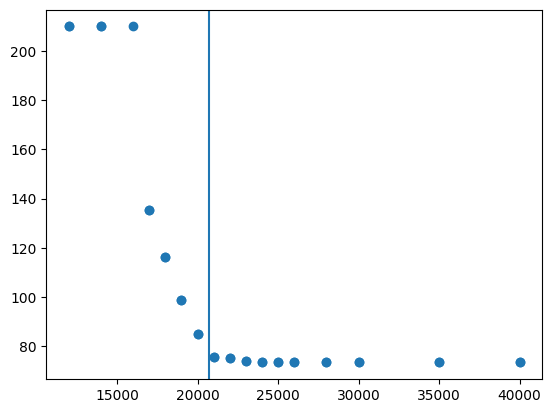

In [8]:
random_instrument = instruments_df.sample(1).iloc[0]["instrument_name"]
single_strike = instruments_df[
    (instruments_df["instrument_name"].str.startswith(random_instrument[0:11])) 
#     (instruments_df["instrument_name"].str.endswith(random_instrument[-1]))
]
single_strike_ids = single_strike.instrument_id.to_list()

options = pd.DataFrame(columns = single_option.columns.values)
for op_id in single_strike_ids:
    try:
        option = collect_single_instrument_data(instrument_id = op_id, number_of_ticks = 1)
        options = options.append(option)
    except:
        continue
    
plt.scatter(options["strike"], options["mark_iv"])
plt.axvline(x=option.iloc[0]["underlying_price"])
plt.show()

In [7]:
exp_date = options.iloc[0].instrument_name[:11]
print(f"Expirety date: {exp_date}")
options.to_pickle(f"data/{exp_date}.pkl")

Expirety date: BTC-27JAN23
